In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10

Using TensorFlow backend.


In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

126066688/170498071 [=====================>........] - ETA: 23s170500096/170498071 [==============================] - 82s 0us/step


In [0]:
input_shape = [None, 32, 32, 3]
number_of_classes = 10

#Conver output label to one hot vector
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)

In [14]:
print("Shape of training features: {}".format(x_train.shape))
print("Shape of training lables: {}".format(y_train.shape))
print("Shape of testing features: {}".format(x_test.shape))
print("Shape of testing lables: {}".format(y_test.shape))

Shape of training features: (50000, 32, 32, 3)
Shape of training lables: (50000, 10)
Shape of testing features: (10000, 32, 32, 3)
Shape of testing lables: (10000, 10)


In [0]:
#Hyper parameters
learning_rate = 0.01
epoch = 10
batch_size = 32

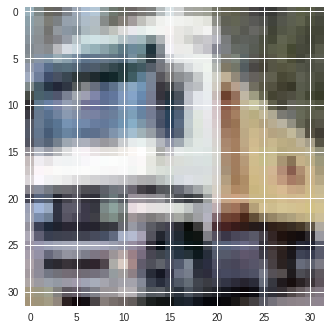

In [8]:
plt.imshow(x_train[1])

In [16]:
x_train, cv_x, y_train, cv_y = train_test_split(x_train, y_train, 
                                                test_size = 5000, random_state = 42)

print("Number of examples in training set: {}".format(x_train.shape[0]))
print("Number of examples in cross validation set: {}".format(cv_x.shape[0]))

Number of examples in training set: 45000
Number of examples in cross validation set: 5000


In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
#GRAPH

#Resetting graph
tf.reset_default_graph()

#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])
train_mode = tf.placeholder(tf.bool)

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'

filter_size = 3

with tf.name_scope('Model'):
    #Convolutional Layer 1 + RELU
    convo_1 = tf.layers.conv2d(inputs=x,filters=32, kernel_size = [filter_size,filter_size], padding="same", activation=tf.nn.relu)
    #Convolutional Layer 2 + RELU
    convo_2 = tf.layers.conv2d(inputs=convo_1,filters=64, kernel_size = [filter_size,filter_size], activation=tf.nn.relu)
    #Pooling Layer 1
    pooling_1 = tf.layers.max_pooling2d(inputs=convo_2, pool_size=[2, 2], strides=2)
    dropout_1 = tf.layers.dropout(pooling_1,rate=0.25, training= train_mode)
    
    #Convolutional Layer 3 + RELU
    convo_3 = tf.layers.conv2d(inputs=dropout_1,filters=64, kernel_size = [filter_size,filter_size], padding="same", activation=tf.nn.relu)
    #Convolutional Layer 4 + RELU
    convo_4 = tf.layers.conv2d(inputs=convo_3,filters=128, kernel_size = [filter_size,filter_size], activation=tf.nn.relu)
    #Pooling Layer 2
    pooling_2 = tf.layers.max_pooling2d(inputs=convo_4, pool_size=[2, 2], strides=2)
    dropout_2 = tf.layers.dropout(pooling_2,rate=0.25, training= train_mode)
    
    #Flattening
    flatten = tf.reshape(dropout_2,[-1,6*6*128])
    #Fully Connected 1 + RELU
    full_layer_one = tf.layers.dense(inputs=flatten, units = 512, activation=tf.nn.relu)
    #Dropout Layer 1
    full_one_dropout = tf.layers.dropout(full_layer_one,rate=0.5, training= train_mode)
    #Output Layer,containing 2 output nodes.
    y_pred = tf.layers.dense(inputs=full_one_dropout,units=10)

#Loss function
with tf.name_scope('Loss'):
    loss = tf.losses.softmax_cross_entropy(y_true, y_pred)

#Optimizer Function
with tf.name_scope('ADAM'):
     train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

#Defining Accuracy
with tf.name_scope('Accuracy'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1)), tf.float32))

In [60]:
saver = tf.train.Saver()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    
    total_size = x_train.shape[0]
    number_of_batches = int(total_size/batch_size)
    
    print("Training:Start")
    for e in range(epoch):
        epoch_cost = 0
        epoch_accuracy = 0
        for i in range(number_of_batches):
            mini_x = x_train[i*batch_size:(i+1)*batch_size, :, :, :]
            mini_y = y_train[i*batch_size:(i+1)*batch_size, :]
            _, cost = sess.run([train_op,loss], feed_dict={x:mini_x, y_true:mini_y,train_mode:True})
            train_accuracy = sess.run(accuracy, feed_dict={x:mini_x, y_true:mini_y,train_mode:False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        epoch_cost /= number_of_batches
        
        if total_size % batch_size != 0:
            epoch_accuracy /= (number_of_batches+1)
        else:
            epoch_accuracy /= number_of_batches
        print("Epoch: {} Cost: {} accuracy: {} ".format(e+1, np.squeeze(epoch_cost), epoch_accuracy))
    
    a = tf.argmax(y_pred, 1)
    print(a.eval(feed_dict={x:x_train[0:1,:,:,:],train_mode:False}))
    save_path = saver.save(sess, "drive/Colab Notebooks/CIFAR-10/model.ckpt")
    print("Model saved in path: %s" % save_path)

Training:Start
Epoch: 1 Cost: 1.717341889527919 accuracy: 0.3974991115849325 
Epoch: 2 Cost: 1.3639636663759755 accuracy: 0.542866027007818 
Epoch: 3 Cost: 1.2148108573505922 accuracy: 0.6045664534470505 
Epoch: 4 Cost: 1.1090097642724916 accuracy: 0.6480987917555082 
Epoch: 5 Cost: 1.021113065279395 accuracy: 0.681703091684435 
Epoch: 6 Cost: 0.9508058969487846 accuracy: 0.709155117270789 
Epoch: 7 Cost: 0.8878147993581224 accuracy: 0.7331867448471926 
Epoch: 8 Cost: 0.8376032652208849 accuracy: 0.7542643923240938 
Epoch: 9 Cost: 0.7900279221544904 accuracy: 0.7730765813788202 
Epoch: 10 Cost: 0.7431189785810826 accuracy: 0.7914001421464109 
[3]
Model saved in path: drive/Colab Notebooks/CIFAR-10/model.ckpt


## Eğitilen Ağın Performansının Daha Doğru Bir Şekilde Ölçülebilmesi İçin Farklı Random-State Değerleri ile Ağı 5 Defa Daha Sıfırdan Eğitip Elde Edilen Doğruluk Oranlarının Ortalamasını Hesaplıyorum.

 Böylece bir önceki kısımdaki gibi ağı sürekli aynı test ve train verileri ile eğitmek yerine her çalıştırmada(run) farklı train ve test verilerini kullandım.

In [0]:
X = np.concatenate((x_train[:,:,:,:],x_test[:,:,:]),axis=0)
y = np.concatenate((y_train[:,:],y_test[:,:]),axis=0)

from  sklearn.model_selection import train_test_split

In [17]:
# VERİ SETİNİN FARKLI RANDOM-STATE DEĞERLERİ İÇİN TEKRAR EĞİTİLMESİ VE TEST EDİLMESİ

with tf.Session(config=config) as sess:
    
   
  random_states = [10, 42, 83, 143, 251]
  test_accuracies = []
  batch_test_acc = []

  
  for i in range(5):
    sess.run(tf.global_variables_initializer())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_states[i])

    total_size = X_train.shape[0]
    number_of_batches = int(total_size/batch_size)
    print("Random =", str(i))
    
    print("Training:Start")
    # Training Epoch
    for e in range(epoch):
        # Training Batch
        epoch_cost = 0
        epoch_accuracy = 0
        for i in range(number_of_batches):
            mini_x = X_train[i*batch_size:(i+1)*batch_size, :, :, :]
            mini_y = y_train[i*batch_size:(i+1)*batch_size, :]
            _, cost = sess.run([train_op,loss], feed_dict={x:mini_x, y_true:mini_y,train_mode:True})
            train_accuracy = sess.run(accuracy, feed_dict={x:mini_x, y_true:mini_y,train_mode:False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        epoch_cost /= number_of_batches

        if total_size % batch_size != 0:
            epoch_accuracy /= (number_of_batches+1)
        else:
            epoch_accuracy /= number_of_batches
        print("Epoch: {} Cost: {} accuracy: {} ".format(e+1, np.squeeze(epoch_cost), epoch_accuracy))
    
    # Test Batch
    total_size = y_test.shape[0]
    number_of_batches = int(total_size/batch_size)
    test_accuracy = 0
    for i in range(number_of_batches):
      mini_x = X_test[i*batch_size:(i+1)*batch_size, :, :, :]
      mini_y = y_test[i*batch_size:(i+1)*batch_size, :]
      batch_accuracy = sess.run(accuracy, feed_dict={x:mini_x, y_true:mini_y,train_mode:False})
      test_accuracy += batch_accuracy

    if total_size % batch_size != 0:
        test_accuracy /= (number_of_batches+1)
    else:
        test_accuracy /= number_of_batches
    print("Test Accuracy:", test_accuracy)

    test_accuracies.append(test_accuracy)
    print("*"*50)
  print("Mean Accuracy:", np.mean(test_accuracies))
    

Random = 0
Training:Start
Epoch: 1 Cost: 1.7284195787256413 accuracy: 0.3945 
Epoch: 2 Cost: 1.397501811764457 accuracy: 0.5297045454545455 
Epoch: 3 Cost: 1.252150617686185 accuracy: 0.5888181818181818 
Epoch: 4 Cost: 1.1481414057558232 accuracy: 0.6297272727272727 
Epoch: 5 Cost: 1.0646370544000106 accuracy: 0.6659772727272727 
Epoch: 6 Cost: 0.992348838372664 accuracy: 0.69575 
Epoch: 7 Cost: 0.9291473836898804 accuracy: 0.72075 
Epoch: 8 Cost: 0.8761960230740634 accuracy: 0.7414318181818181 
Epoch: 9 Cost: 0.8261348401849921 accuracy: 0.7615681818181819 
Epoch: 10 Cost: 0.7804373869245702 accuracy: 0.7794318181818182 
Test Accuracy: 0.7170239825581395
**************************************************
Random = 1
Training:Start
Epoch: 1 Cost: 1.7023617825508117 accuracy: 0.4027045454545455 
Epoch: 2 Cost: 1.3719317113269458 accuracy: 0.5357727272727273 
Epoch: 3 Cost: 1.229983094215393 accuracy: 0.5961136363636363 
Epoch: 4 Cost: 1.1141033100214872 accuracy: 0.6421136363636364 
Epoc

In [18]:
# Eğitilen modeli istenilen isim ile kaydedebilirsiniz.

# Eğitilen model ile tahmin işleminin gerçekleştirilmesi
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "drive/Colab Notebooks/CIFAR-10/model.ckpt")
    prediction = tf.argmax(y_pred, 1)
    print("Actual Class:",y_train[100:101,:])
    print("Predict Class:",prediction.eval(feed_dict={x:x_train[100:101,:,:,:],train_mode:False}))

INFO:tensorflow:Restoring parameters from drive/Colab Notebooks/CIFAR-10/model.ckpt
Actual Class: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Predict Class: [7]


In [0]:
import os
import cv2
from tqdm import tqdm

TEST_DIR = 'drive/Colab Notebooks/CIFAR-10/Test_Images'
IMG_SIZE = 32

# Bu kısmı dışarıdan kullanıcı resim verdiğinde direkt olarak ağın anlayabileceği sayısal değerlere nasıl dönüştürüleceğini anlatabilmek adına yazdım.
# Verilen klasördeki resimler okunur ve ağın anlayabileceği sayısal verilere dönüştürülür. OpenCV kütüphanesi ile kullanılır.
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = img
        path = TEST_DIR + '/' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),label])
      
    # Elde edilen matris istenirse .npy formatında kaydedilip. Paylaşılabilir.
    #shuffle(testing_data)
    #np.save('test_data_bi.npy', testing_data)
    return testing_data

In [0]:
# Load Data
my_images = process_test_data()

# Reshape Data
test_img = np.array([i[0] for i in my_images]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
labels = np.array([i[1] for i in my_images])

INFO:tensorflow:Restoring parameters from drive/Colab Notebooks/CIFAR-10/model.ckpt
Actual Class: ucak.jpg
Predict Class: Uçak


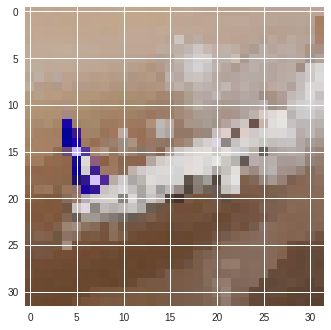

In [95]:
saver = tf.train.Saver()
cifar_classes = {0:'Uçak',1:'Otomobil',2:'Kuş',3:'Kedi',4:'Geyik',5:'Köpek',6:'Kurbağa',7:'At',8:'Gemi',9:'Tır'}

# Resimlerden tahminlere.
with tf.Session(config=config) as sess:
    saver.restore(sess, "drive/Colab Notebooks/CIFAR-10/model.ckpt")
    prediction = tf.argmax(y_pred, 1)
    index = 0
    pred_Val = prediction.eval(feed_dict={x:test_img[index:index+1,:,:,:],train_mode:False})
    print("Actual Class:",labels[index])
    print("Predict Class:",cifar_classes[pred_Val[0]])
    plt.imshow(test_img[index])